<a href="https://colab.research.google.com/github/holly-hewitt/ML-Practical-Coursework/blob/main/Copy_of_adaptive_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coursework 2 (Practical) for COMPSCI4061 / COMPSCI5014 Machine Learning H / M - 2023-24

### Problem Statement

The explicit task description for this assignment is at the bottom of this notebook.

In this assignment, we are going to explore an adaptive K-NN classifier. Usually, for K-NN classification (which is a non-parametric approach), we work with a fixed value of $k$. After storing the data instances and the labels, during the inference time for each point, we get its $k$-neighborhood and predict the majority label from its neighborhood as the label of the current point.

In this report, we are going to investigate if a variable $k$ (the value of which depends on the data instance) performs better than a static choice of $k$.

We are going to implement two different approaches - one based on heuristics, and the other based on a supervised parametric classifier that predicts the value of $k$ given a data instance.

The following block of code downloads and prepares the dataset to be used. It also shows some sample images from the training set.

11490434/11490434 [==============================] - 1s 0us/step


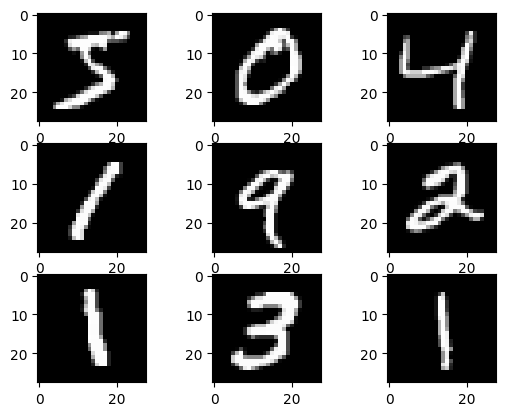

Train samples: (60000, 784) (60000, 1)
Test samples: (10000, 784) (10000, 1)
Evaluation set: (100, 784)
Train samples: (60000, 784) (60000,)
Test samples: (100, 784) (100,)


In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

pyplot.show()


# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

NUM_TRAIN_SAMPLES = x_train.shape[0]
NUM_TEST_SAMPLES = x_test.shape[0]

print("Train samples: {} {}".format(x_train.shape, y_train.shape))
print("Test samples: {} {}".format(x_test.shape, y_test.shape))

# We conduct all the evaluation on a *small subset* of the test data
EVAL_SUBSET_SIZE = 100
eval_ids = np.random.randint(NUM_TEST_SAMPLES, size=EVAL_SUBSET_SIZE)
x_test = x_test[eval_ids,:]
y_test = y_test[eval_ids,:]

print("Evaluation set: {}".format(x_test.shape))

NUM_TRAIN_SAMPLES = x_train.shape[0]
NUM_TEST_SAMPLES = x_test.shape[0]
y_train = y_train.ravel()
y_test = y_test.ravel()

print("Train samples: {} {}".format(x_train.shape, y_train.shape))
print("Test samples: {} {}".format(x_test.shape, y_test.shape))

#### Learning with noisy labels

To demonstrate the necessity of the adaptive approach, we simulate noisy data by introducing the common mistakes.
For instance, we randomly change 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.

The amount of noise injected as a part of this stochastic process is controlled by the paramater **noise_probability** ($\in [0, 1]$).


In [2]:
import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        p = random.random()

        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))


Corruptions: {'5->8': 658, '0->3': 694, '4->2': 645, '9->2': 739, '1->6': 692, '4->8': 548, '3->5': 720, '6->3': 709, '7->9': 620, '2->6': 686, '8->6': 695, '6->8': 714, '9->3': 699, '4->6': 567, '1->0': 675, '2->0': 751, '2->5': 700, '3->0': 722, '9->0': 688, '0->9': 654, '5->2': 639, '0->5': 724, '6->0': 718, '1->5': 645, '8->3': 761, '7->5': 624, '9->8': 675, '9->6': 732, '3->2': 737, '7->0': 609, '4->3': 570, '8->2': 684, '1->9': 672, '4->0': 587, '6->5': 694, '0->2': 704, '4->5': 571, '5->3': 641, '1->8': 732, '7->2': 656, '0->6': 675, '2->3': 677, '3->8': 699, '4->9': 622, '6->2': 688, '7->8': 595, '8->5': 657, '7->6': 629, '1->3': 661, '3->9': 736, '2->8': 681, '3->6': 704, '2->9': 658, '8->9': 639, '6->9': 694, '1->2': 700, '9->5': 668, '5->9': 618, '5->6': 648, '5->0': 646, '7->3': 668, '0->8': 667, '8->0': 692}
Corrupted indexes: [0, 1, 2, 4, 8, 9, 12, 13, 15, 16]


### Standard K-NN on this noisy data

We now execute static k-NN on this noisy data. The effectiveness of the classifier is very poor (for your own understanding, try to see why; note that answering this is not an actionable item and hence isn't graded).

In [3]:
K = 3

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=K)
model.fit(x_train, y_train)

print ("{}-NN model fitted".format(K))

y_preds = model.predict(x_test)
print ("K-NN model accuracy with k={}: {:.4f}".format(K, accuracy_score(y_test, y_preds)))

3-NN model fitted
K-NN model accuracy with k=3: 0.2700


We now would implement a simple unsupervised (heuristic-based) method to predict if we need a large or a small value of $k$ for a correct classification. Recall from the lecture notes that a dense neighborhood perhaps would be better served with a large value of $k$, whereas a relatively less compact neighborhood may do well with a small $k$. A sample function to estimate the quality of a neighborhood is the variance of the distances of the neighborhood points, i.e.,

$$\phi(N_k(\mathbf{x})) = \sum_{z \in N_k(\mathbf{x})} (d(\mathbf{x},\mathbf{z}) - \mu)^2, \text{where}\,\,\,\,\mu=\sum_{z \in N_k(\mathbf{x})} d(\mathbf{x},\mathbf{z}).$$

Notations:
 * $\mathbf{x}$: A data instance for inference.
 * $N_k(\mathbf{x})$: A neighborhood of size $k$ around the data instance for inference.
 * $d(\mathbf{x},\mathbf{z})$: Distance (Euclidean or cosine or any other) between the test point $\mathbf{x}$ and a training point $\mathbf{z}$.
 * $\mu$: The average of the distances of the neighboring training points from the test point.   


Again for your own understanding, try to see wheether it makes sense to argue that the higher the variance, the less compact is the neighborhood, and perhaps we want a smaller $k$ for such ones? (no actionable item and no grading for finding this answer)

Our task is now to write the function *predict_k_values_unsupervised*.

In [4]:
import math

# Takes the test set and an index of nearest neighbors.
# Iterates over each point, computes the variance of distances, scales that into the range [1, MAX_K]
# and returns a list of adaptively chosen K values (one for each instance).
def predict_k_values_unsupervised(x_test, nn_index):
    n = x_test.shape[0]
    variances = []
    for i in range(n):
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x], return_distance=True)
        variances.append(np.var(distances))

    min_v = min(variances)
    max_v = max(variances)

    k_values = [1 + math.floor((MAX_K-1) * (float(var) - min_v)/(max_v - min_v)) for var in variances]
    return k_values

In [5]:
# For adaptively choosing $k$ we need to set an upper bound (the lower bound being 1).
MAX_K = 20

from sklearn.neighbors import NearestNeighbors

def adaptive_knn(x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    print ("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    k_values = predict_k_values_unsupervised(x_test, nn_index)
    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        #print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

In [6]:
accuracy = adaptive_knn(x_test, y_test)
print ("Adaptive K-NN model accuracy: {:.4f}".format(accuracy))

20-NN index built


KeyboardInterrupt: ignored

#### Tasks: Investigate if we can do better than the heuristics.

We now seek to learn a function of the form $\theta: \mathbf{x} \mapsto \mathbb{Z}_k$ (e.g., via $k$-class softmax regression or an SVM or any other parametric classifier).

**Task 1 (30 marks)**: Replace the function *predict_k_values_unsupervised* with another function *predict_k_values_supervised* which will do the following:
- Learn a mapping between a data instance from the training set and the smallest value of $k$ that results in correct predictions for that instance. In your report, clearly describe how do you train this classifier (e.g., what are the ground-truth y values for each training data point $\mathbf{x} \in S_{train}$.    
- Apply this paramateric model to *predict* the value of $k$ at inference time (for this you just need to replace the call to **predict_k_values_unsupervised** inside **adaptive_knn** with your implemented method).

**Task 2 (30 marks)**: Compare the performance of your implemented supervised approach vs. the baseline (unsupervised one) for different simulated datasets with varying amounts of noise. Make a plot with *noise_probability* on the x-axis and accuracy on the y-axis for 11 different values - {0, 0.1, ... 0.9, 1}.

**Task 3 (40 marks)**: Write a commentary on the observations reflecting on your approach (e.g., on the assumptions you make, on the hyper-parameter choices for your method etc.) and figuring out **when and why it works** (e.g., for what hyper-parameter settings), and **when and why it doesn't**.
  - 3(a): Clear description of the assumptions, the experiment settings (e.g., different levels of noises) and hyper-parameters of your approach (e.g., learning rate or regularisation constant of softmax regression) (10 marks).
  - 3(b): Sensitivity analysis of the hyper-parameters (ideally should be demonsrated with plots of results) (15 marks).
  - 3(c): Your observations and conclusions on per-instance error analysis, e.g., what happens in different types (different levels of compactness or homogeneity) of neighborhoods (15 marks).





---

*Task 1: *

- gen_k_vals is a function that finds the minimuk value of k for each x instance that will result in a correct prediction of y
- it is quite slow... not ideal
- however, as we are creating a supervised approach, we need to create a training dataset for the k values
- it feels inefficient to do this sort of this when the true values won't actually be used, instead a model predicting the values will be used. HOWEVER, obviosuly it does make sense as we want our model to generalise outside of the training and test data

In [ ]:
# Retry: Finding k truth values

# For adaptively choosing $k$ we need to set an upper bound (the lower bound being 1).
MAX_K = 20

from sklearn.neighbors import NearestNeighbors

def gen_k_vals(x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    print ("{}-NN index built".format(MAX_K))
    k_values = []

    for i in range(len(x_test)):
        if (i%100)==0:
          print("x value", i)
        k = 0
        correct = False

        x = x_test[i]
        y = y_test[i]

        #print ("Predicting with nn-size = {}".format(k))
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:MAX_K] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        while not correct and k<MAX_K:
          k += 1
          y_pred = max(set(nn_labels[:k]), key=nn_labels[:k].count)
          correct = (y_pred == y)
        print(k)

        k_values.append(k)
    return k_values

In [ ]:
# The code is too slow to generate k_train from all of the training data
k_test = gen_k_vals(x_test, y_test)
print(k_test)

How can we create k_train if the nearest neighbour model is fitted using k_train? It is producing 1 nearest neighbour and all are having the correct classification. only one result for k. We need to investigate why this is....


Task 1: Attempt 1

- Use a multinomial logistic regression model with the data
- Accuracy not any better than the naive method
- HOWEVER: we only used 10% of our training set to train the model. It is not a fair comparison?

In [ ]:
from sklearn.linear_model import LogisticRegression
# fit a model using x_train and k_train
# model chosen multinomial logistic regression model
def predict_k_values_supervised(x_test):

  lr_model = LogisticRegression(multi_class='multinomial')
  lr_model.fit(x_train[:6000], k_train)

  # Predict k values for the test set
  k_pred = lr_model.predict(x_test)

  # Print or use the predicted k values as needed
  return(k_pred)


In [ ]:
# For adaptively choosing $k$ we need to set an upper bound (the lower bound being 1).
MAX_K = 20

from sklearn.neighbors import NearestNeighbors

def adaptive_knn_v1(x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    print ("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    k_values = predict_k_values_supervised(x_test)
    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        #print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

In [ ]:
accuracy = adaptive_knn_v1(x_test, y_test)
print ("Adaptive K-NN model accuracy: {:.4f}".format(accuracy))

In [ ]:
import numpy as np

unique_classes_train = np.unique(k_train)
print("Unique classes in k_train:", unique_classes_train)
print(k_train)

In [ ]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


Task 1: Attempt 2

Use a SVM model with the data

In [ ]:
from sklearn.svm import SVC
def predict_k_values_supervised(x_test):
  svc_model = SVC(C=1000, kernel='linear')
  svc_model.fit(x_train, k_train)

  # Predict k values for the test set
  k_pred = svc_model.predict(x_test)
  return k_pred

In [ ]:
accuracy = adaptive_knn(x_test, y_test)
print ("Adaptive K-NN model accuracy: {:.4f}".format(accuracy))

In [7]:
def gen_k_ground_truth(x_test, y_test, x_train, y_train, subsample_fraction = 0.1):
  # Use a subsample of the training data to build the k-NN index
    subsample_size = int(len(x_train) * subsample_fraction)
    subsample_indices = np.random.choice(len(x_train), subsample_size, replace=False)
    x_train_subsample = x_train[subsample_indices]
    y_train_subsample = y_train[subsample_indices]
    nn_index = NearestNeighbors(n_neighbors=len(x_train_subsample)).fit(x_train_subsample)

    print("{}-NN index built with a subsample of {} training instances".format(len(x_train_subsample), subsample_size))

    subsample_size = int(len(x_test) * subsample_fraction)
    subsample_indices = np.random.choice(len(x_test), 0.4, replace=False)
    x_test_subsample = x_test[subsample_indices]
    y_test_subsample = y_test[subsample_indices]

    k_values = []
    print(len(x_test_subsample))

    for i in range(len(x_test_subsample)):


        x = x_test_subsample[i]
        y = y_test_subsample[i]

        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:len(x_train_subsample)]  # take the first k (out of the subsample)
        nn_labels = [y_train_subsample[x_id] for x_id in ids]

        k = 1
        while k < MAX_K:
            y_pred = max(set(nn_labels[:k]), key=nn_labels[:k].count)
            if y_pred == y:
                break
            k += 1
        if (i % 100) == 0:
            print("x value", i)
            print(k)
        k_values.append(k)

    return k_values


In [ ]:
k_vals = gen_k_ground_truth(x_test, y_test, x_train, y_train )
print(k_vals)

In [ ]:

x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test, k_vals, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(x_train_k, k_train_k)




In [ ]:
from sklearn.model_selection import train_test_split

# create subsamples of x_train and y_train for creating ground truth values of k

x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

k_vals = gen_k_ground_truth(x_test_sub, y_test_sub, x_train_sub, y_train_sub)




In [13]:
x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test_sub, k_vals, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(x_train_k, k_train_k)

LogisticRegression(max_iter=1000, random_state=42)

In [17]:
def predict_k_values_unsupervised(x_test):
  # Train a logistic regression classifier
  classifier = LogisticRegression(max_iter=1000, random_state=42)
  classifier.fit(x_train_k, k_train_k)
  # Predict k values for the test set
  k_pred = classifier.predict(x_test)

  # Print or use the predicted k values as needed
  return(k_pred)

k_vals_LR_pred = predict_k_values_unsupervised(x_test)

In [18]:
# For adaptively choosing $k$ we need to set an upper bound (the lower bound being 1).
MAX_K = 20

from sklearn.neighbors import NearestNeighbors

def adaptive_knn_v1(x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    print ("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    k_values = k_vals_LR_pred
    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        #print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

In [20]:
accuracy = adaptive_knn_v1(x_test, y_test)
print ("Adaptive K-NN model accuracy: {:.4f}".format(accuracy))

20-NN index built
Adaptive K-NN model accuracy: 0.5400


The model works!!!!